In [371]:
import os
import sys
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# CSCA 5622: Final Project

Karl Schmidt <br>
02/01/2025

# Table of Contents

* [Introduction](#introduction)
   * [Purpose](#purpose)
   * [Scope](#scope)
* [Methodology](#methodology)
   * [Dataset Description](#dataset-description)
      * [M2 Money Supply](#m2-money-supply)
      * [Bitcoin Google Trends](#google-trends)
      * [Bitcoin Daily Active](#bitcoin-daily-active)
      * [Bitcoin Address Blances](#bitcoin-address-blances)
      * [Blockchain.com Daily](#blockchain-dot-com)
      * [Sentiment Analysis](#sentiment-analysis)
   * [Model Selection](#model-selection)
      * [AdaBoost](#selecting-adaboost)
      * [Random Forest](#selecting-random-forest)
      * [Support Vector Machine](#selecting-support-vector-machine)
* [Implementation](#implementation)
   * [Data Cleaning & Preprocessing](#data-cleaning-and-preprocessing)
      * [Normalizing Data](#normalizing-data)
      * [Caveats, Known Issues, & Findings](#caveats-known-issues-and-findings)
      * [EDA Results Discussion](#eda-results-discussion)
         * [Missing Data](#missing-data)
         * [Statistical Summary](#statistical-summary)
         * [Observations from the Data Distribution](#observations-from-the-data-distribution)
         * [Visualization Insights](#visualization-insights)
         * [Conclusion](#conclusion)
   * [Exploratory Data Analysis](#exploratory-data-analysis)
   * [Tuning Models](#tuning-models)
      * [Tuning AdaBoost](#tuning-adaboost)
      * [Tuning Random Forest](#tuning-random-forest)
      * [Tuning Support Vector Machine](#tuning-support-vector-machine)
   * [Ensembling](#ensembling)
* [Results & Analysis](#results-and-analysis)
   * [Model Analysis](#model-analysis)
      * [AdaBoost Performance Analysis](#adaboost-performance-analysis)
      * [Random Forest Performance Analysis](#random-forest-performance-analysis)
      * [Support Vector Machine Performance Analysis](#support-vector-machine-performance-analysis)
   * [Results](#results)

# Introduction <a class="anchor" id="introduction"></a>

This is a project for the CSCA 5622 Supervised Learning Courser part of the MSCS CU Boulder program. This project aims to build an ensemble from several regressive classifiers to create a predictive model for Bitcoin data. The goal is to utilize a range of data from on-chain Bitcoin data, Bitcoin metric data, price data, sentiment, and some macro economic data to train, help optimize, and validate our various models. Additionally, there will be some additional features which aim to increase the performance of models, including a running average and the previous days price.

Bitcoin has garnered popular and traditional finance support through recent years. Since its initial proposal in 2008, it has been proven to be a volatile asset that cycles peaks and lows over a four year cycle. It should be noted that, in order to build a likely significantly more accurate model, several various methods should be analyzed which includes additional machine learning models beyond the regressive or classification models taught within this course. Additionally, quality and complete cycle data should be used to fully train models if the intent is to use them in actual trading. As such, it should be noted that this is a simple project intended to learn supervised learning methods and should not be taken as financial advice. It is likely that the model developed in this report will be far from worthy for making any sort of Bitcoin investment decisions.

## Purpose <a class="anchor" id="purpose"></a>

The purpose of this project is to:

 1. Optimize AdaBoost, Random Forest, and SVM in predicting Bitcoin’s price.
 2. Utilize these optimized models to construct and ensemble to improve the accuracy and decrease the variance of predictions.
 3. Identify key features influencing Bitcoin price movements.
 4. Evaluate the models based on accuracy and generalization to unseen data.
 5. Provide a foundation for further research in cryptocurrency price forecasting.

## Scope <a class="anchor" id="scope"></a>

This project will limit its scope to hyperparameter tuning for each individual regression model, apply a simple mean aggregation of these models and perform an analysis of its performance by looking at mean absolute error (MAE), mean squared error (MSE), and the coefficient of determination or R-squared (R2). Given that this is a jupyter notebook, flow of the document may be broken up by code. The intent is to have cells with "chunks" of code that are easier to read. As such, all description will be presented before the code blocks with the analysis writeup after the code blocks.

# Methodology <a class="anchor" id="methodology"></a>

This report uses three separate classification models: (1) AdaBoost, (2) Random Forest, and (3) Support Vector Machine. These models will be trained by the datasets described below.

## Dataset Description <a class="anchor" id="dataset-description"></a>

The datasets used in this project comprise a combination of macroeconomic indicators, Bitcoin network data, blockchain statistics, and sentiment analysis. The data spans from **1960** to **2025**, with varying granularities (monthly, daily, or per transaction).

### M2 Money Supply <a class="anchor" id="mondey-supply"></a>

The M2 Money Supply (M2S) is a broad measure of the total amount of dollars circulating in the economy. The dataset is included because the supply of money is often correlated with the appreciation of various assets, including Bitcoin, within macroeconomic trends. Typically, Bitcoin's price experiences high and low peaks around a four-year cycle, which may correlate with M2S, especially considering the effects of quantitative easing (QE) and quantitative tightening (QT) implemented by the Federal Reserve. QE generally occurs when the U.S. government extends the debt limit, often in response to the need to pay off national debt, which leads to inflation. The Federal Reserve typically responds to this inflation by removing money from circulation.

[M2 Money Supply[1960, 2025]](https://fred.stlouisfed.org/series/M2SL)

 - **Granularity:** Monthly (from **1960** to **2025**)
 - **Size:** 2 Columns, 22 Rows
 - **Data Columns**
   - *observation_date*: The month for each M2S data reading.
   - *M2SL*: The total money supply.

### Google Trends <a class="anchor" id="google-trends"></a>

Google Trends data is included as an additional metric to capture investor interest. The assumption is that when the price of Bitcoin is rising, more individuals search for Bitcoin-related topics, and when the price falls, search interest decreases.

[Bitcoin Google Trends[2011, 2025]](https://charts.bgeometrics.com/google_trends.html)

 - **Granularity:** Daily (from **2011** to **2025**)
 - **Size:** 2 Columns, 657 Rows
 - **Data Columns:**
   - *DateTime*: The timestamp for each data entry. 
   - *BTC price*: The price of Bitcoin.
   - *Google Trends*: The number of Google searches related to Bitcoin for each date.

### Bitcoin Daily Active <a class="anchor" id="bitcoin-daily-active"></a>

The Bitcoin Daily Active Data includes various calculated values such as the Fear and Greed index, derived from metrics within the Bitcoin network.

[Bitcoin On-Chain [2009, 09-02-2023]](https://www.kaggle.com/datasets/aleexharris/bitcoin-network-on-chain-blockchain-data?select=blockchain_dot_com_daily_data.csv)

 - **Granularity:** Daily (from **2009** to **2023**)
 - **Size:** 12 columns, 666 rows
 - **Data Columns:**
   - *datetime*: The timestamp for each data entry.
   - *market_price_usd*: The Bitcoin price in USD.
   - *total_supply*: The total supply of Bitcoin tokens.
   - *market_cap_usd*: The total market capitalization of Bitcoin in USD.
   - *realised_cap_usd*: The value of the Bitcoin network based on the price at which each coin last moved on-chain.
   - *nupl*: Net Unrealized Profit/Loss, calculated as the market capitalization minus realized capitalization, divided by market capitalization.
   - *coin_days_destroyed*: A measure of the number of coins transacted and how long they remained unspent.
   - *active_addresses*: The number of daily active Bitcoin addresses.
   - *fear_greed_value*: A sentiment indicator measuring market emotions, ranging from extreme fear (0-24) to extreme greed (75-100).
   - *fear_greed_category*: The category of the Fear and Greed Index.
   - *lightning_nodes*: The number of nodes running on the Lightning Network.
   - *lightening_capacity_usd*: The total value of Bitcoin (in USD) locked in the Lightening Network.


### Bitcoin Address Blances <a class="anchor" id="bitcoin-address-blances"></a>

This dataset contains information on Bitcoin wallet addresses, categorized by different levels of Bitcoin holdings.

[Bitcoin On-Chain Data [2009, 09-02-2023]](https://www.kaggle.com/datasets/aleexharris/bitcoin-network-on-chain-blockchain-data?select=blockchain_dot_com_daily_data.csv)

 - **Granularity:** Daily (from **2009** to **2023**)
 - **Size:** 12 columns, 667 rows
 - **Data Columns:**
   - *date*: The date of each data entry.
   - *market_price_usd*: The Bitcoin price in USD.
   - *addresses_with_1000_btc*: The number of addresses holding 1000 BTC or more.
   - *addresses_with_100_btc*: The number of addresses holding 100 BTC or more.
   - *addresses_with_10_btc*: The number of addresses holding 10 BTC or more.
   - *addresses_with_1_btc*: The number of addresses holding 1 BTC or more.
   - *addresses_with_0.01_btc_x*: The number of addresses holding 0.01 BTC or more (partially split for data representation).
   - *addresses_with_0.01_btc_y*: A further split for addresses holding 0.01 BTC or more.

### Blockchain.com Daily <a class="anchor" id="blockchain-dot-com"></a>

This dataset includes various metrics related to the Bitcoin network, such as transaction rates, hash rate, and miner revenues.

[Bitcoin On-Chain Data [2009, 09-02-2023]](https://www.kaggle.com/datasets/aleexharris/bitcoin-network-on-chain-blockchain-data?select=blockchain_dot_com_daily_data.csv)

 - **Granularity:** Daily (from **2009** to **2023**)
 - **Size:** 12 columns, 667 rows
 - **Data Columns:**
   - *datetime*: The timestamp for each data entry.
   - *mempool_size*: The size of the Bitcoin mempool.
   - *transaction_rate*: The rate of Bitcoin transactions.
   - *market_cap_usd*: The market capitalization of Bitcoin in USD.
   - *average_block_size*: The average size of Bitcoin blocks.
   - *market_price_usd*: The Bitcoin price in USD.
   - *exchange_volume_usd*: The volume of Bitcoin transactions on exchanges.
   - *average_confirmation_time*: The average time for a Bitcoin transaction to be confirmed.
   - *hash_rate*: The total processing power of the Bitcoin network.
   - *difficulty*: The difficulty of mining Bitcoin.
   - *miners_revenue*: The revenue of Bitcoin miners.
   - *total_transaction_fees*: The total transaction fees paid to Bitcoin miners.


### Sentiment Analysis <a class="anchor" id="sentiment-analysis"></a>

The sentiment analysis dataset provides information on Bitcoin-related articles, including sentiment scores that classify the articles as positive or negative regarding Bitcoin. Articles are collected across multiple dates, with daily timestamps assigned by averaging sentiment scores for articles published on the same day.

[Sentiment Analysis of Bitcoin-Related News and Articles[2021, 2024]](https://www.kaggle.com/datasets/imadallal/sentiment-analysis-of-bitcoin-news-2021-2024)

 - **Granularity:** Hourly (from **2021** to **2024**)
 - **Size:** 4 columns, 8318 rows
 - **Data Columns:**
   - *Date*: The date of each sentiment entry.
   - *Short Description*: A brief description of the article.
   - *Accurate Sentiments*: The sentiment score of the article, indicating whether it is positive or negative.




In [422]:
'''
Read in all of the Data
'''
m2_supply          = pd.read_csv('Data/M2SL.csv')
google_trends      = pd.read_csv('Data/bitcoin-google-trends.csv')
sentiment_analysis = pd.read_csv('Data/bitcoin_sentiments_21_24.csv')
additional_daily   = pd.read_csv('Data/look_into_bitcoin_daily_data.csv') 
bitcoin_addresses  = pd.read_csv('Data/look_into_bitcoin_address_balances_data.csv').rename(columns={'Unnamed: 0': 'date'})
on_chain_daily     = pd.read_csv('Data/blockchain_dot_com_daily_data.csv')

In [423]:
print('m2_supply:          ', m2_supply.shape)
print('google_trends:      ', google_trends.shape)
print('sentiment_analysis: ', sentiment_analysis.shape)
print('additional_daily:   ', additional_daily.shape)
print('bitcoin_addresses:  ', bitcoin_addresses.shape)
print('on_chain_daily:     ', on_chain_daily.shape)

m2_supply:           (792, 2)
google_trends:       (5142, 3)
sentiment_analysis:  (11295, 3)
additional_daily:    (4764, 12)
bitcoin_addresses:   (4765, 8)
on_chain_daily:      (5356, 12)


## Model Selection <a class="anchor" id="model-selection"></a>

### AdaBoost <a class="anchor" id="selecting-adaboost"></a>

AdaBoost was selected because of its high precision and versatility to adapt to diverse datasets. Given the wide range of data in our dataset, these is a need for a model which can boost the importance of features which have low correlation to Bitcoin's price. Due to this model's advantage to increase accuracy on the training data, there is a disadvantage to overfitting training data and given Bitcoin's volatility, this could lead to very inaccurate predictions of test or validation datasets. There is also another potential problem with using AdaBoost due to its tendency to overweight outlier data. Investigating our dataset through exploratory analysis will be need to assess what data should or should not be used to train this model.

### Random Forest <a class="anchor" id="selecting-random-forest"></a>

To combate against AdaBoost's potentially high inaccuracy on test and validation datasets due to outliers and overfitting, Random Forest was selected. Random Forest is robust to outliers and noisy labels. Given that a random forst is an ensemble method on its own, it is expected that the variance of this model will be beneficial to helping predict the price of Bitcoin.

### Support Vector Machine <a class="anchor" id="selecting-support-vector-machine"></a>

It is expected that due to the wide variety of the dataset chosen, there is potential for all these models to have quite different predictions. Support Vector Machine does will with high-dimensional data. It should be noted that this model may in fact may decrease the performance of the full ensemble due to its sensitivity to the feature selection. There is also a potential that the data is noisy which will reduce the accuracy of the model. This model was selected in hopes to round out the other two models. It should also be noted that given the range and amount of data for traning could actually make predictions highly inaccurat and it may be needed to remove this model from the ensemble.

## Data Cleaning & Preprocessing

The dataset consists of various data sources, each with different granularity and datetime formats. As a result, several preprocessing steps are necessary to prepare the data for analysis. These steps include: (1) centering the granularity around daily values, (2) handling missing or NaN values, (3) aligning the data to ensure the dates coincide within the same range across datasets, and (4) removing duplicate entries.

To capture the high volatility of price fluctuations, daily values are prioritized. This is important to correlate the different data sources back to the Bitcoin price accurately. Since the granularity of each dataset differs, two approaches are used: (1) forward-filling missing data for datasets with a finer granularity than daily, and (2) averaging values for datasets containing multiple data points per day.

The data is then trimmed to the date range from November 5, 2021, to September 2, 2023, which is the largest overlapping period across all datasets.

Finally, duplicate columns are removed, including those related to market capitalization and total supply. Since the Bitcoin price is determined by dividing the market capitalization by total supply, these metrics are excluded to prevent the model from overemphasizing them. The focus is placed on identifying other factors that correlate with the Bitcoin price.

In [424]:
start_date = pd.to_datetime('2021-11-05')
end_date   = pd.to_datetime('2023-09-02')

# M2 Money Supply
m2_supply['observation_date'] = pd.to_datetime(m2_supply['observation_date'])
m2_supply = m2_supply[(m2_supply['observation_date'] >= start_date) & (m2_supply['observation_date'] <= end_date)]

# Google Trends
google_trends['DateTime'] = pd.to_datetime(google_trends['DateTime'])
google_trends = google_trends[(google_trends['DateTime'] >= start_date) & (google_trends['DateTime'] <= end_date)]

# Sentiment Analysis
sentiment_analysis['Date'] = pd.to_datetime(sentiment_analysis['Date'])
sentiment_analysis = sentiment_analysis[(sentiment_analysis['Date'] >= start_date) & (sentiment_analysis['Date'] <= end_date)]
sentiment_analysis['DateOnly'] = sentiment_analysis['Date'].dt.date
daily_sentiment = sentiment_analysis.groupby('DateOnly')['Accurate Sentiments'].agg(
    ['mean']
).reset_index()
daily_sentiment['normalized_sentiment'] = (
    (daily_sentiment['mean'] - daily_sentiment['mean'].min()) / 
    (daily_sentiment['mean'].max() - daily_sentiment['mean'].min())
)

# On-chain Daily Data
on_chain_daily['datetime'] = pd.to_datetime(on_chain_daily['datetime'])
on_chain_daily = on_chain_daily[(on_chain_daily['datetime'] >= start_date) & (on_chain_daily['datetime'] <= end_date)]

# Address Daily Data
bitcoin_addresses['date'] = pd.to_datetime(bitcoin_addresses['date'])
bitcoin_addresses = bitcoin_addresses[(bitcoin_addresses['date'] >= start_date) & (bitcoin_addresses['date'] <= end_date)]

# Bitcoin Daily Data
additional_daily['datetime'] = pd.to_datetime(additional_daily['datetime'])
additional_daily = additional_daily[(additional_daily['datetime'] >= start_date) & (additional_daily['datetime'] <= end_date)]



In [425]:
# Clean Up Dataframes

m2_supply.rename(columns={'observation_date': 'date'}, inplace=True)
google_trends.rename(columns={'DateTime': 'date'}, inplace=True)
daily_sentiment.rename(columns={'DateOnly': 'date'}, inplace=True)
additional_daily.rename(columns={'datetime': 'date'}, inplace=True)
bitcoin_addresses.rename(columns={'date': 'date'}, inplace=True)
on_chain_daily.rename(columns={'datetime': 'date'}, inplace=True)

m2_supply         = m2_supply.drop(columns=[])
google_trends     = google_trends.drop(columns=['BTC price'])
daily_sentiment   = daily_sentiment.drop(columns=['mean'])
on_chain_daily    = on_chain_daily.drop(columns=['market_cap_usd', 'market_price_usd'])
bitcoin_addresses = bitcoin_addresses.drop(columns=['market_price_usd'])
additional_daily  = additional_daily.drop(columns=['market_cap_usd', 'total_supply', 'market_cap_usd', 'realised_cap_usd', 'nupl', 'fear_greed_category'])

dfs = [m2_supply, google_trends, daily_sentiment, additional_daily, bitcoin_addresses, on_chain_daily]

In [426]:
"""
Check the len of all datasets
"""

print('m2_supply:         ', m2_supply.shape)
print('google_trends:     ', google_trends.shape)
print('daily_sentiment:   ', daily_sentiment.shape)
print('additional_daily:  ', additional_daily.shape)
print('bitcoin_addresses: ', bitcoin_addresses.shape)
print('on_chain_daily:    ', on_chain_daily.shape)

m2_supply:          (22, 2)
google_trends:      (657, 2)
daily_sentiment:    (647, 2)
additional_daily:   (666, 7)
bitcoin_addresses:  (667, 7)
on_chain_daily:     (667, 10)


In [427]:
# Step 1: Create a date range for merging
date_range = pd.DataFrame({'date': pd.date_range(start='2021-01-01', end='2023-09-02')})

for df in dfs:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Step 4: Merge datasets
merged_df = date_range \
    .merge(additional_daily, on='date', how='left') \
    .merge(bitcoin_addresses, on='date', how='left') \
    .merge(on_chain_daily, on='date', how='left') \
    .merge(google_trends, on='date', how='left') \
    .merge(daily_sentiment, on='date', how='left') \
    .merge(m2_supply, on='date', how='outer') \

merged_df = merged_df.ffill()
merged_df = merged_df.dropna()
df = None
df = merged_df.copy()
df.reset_index(drop=True, inplace=True)

# Final output
print("Merged dataset shape:", merged_df.shape)
print("Date Range Start:", date_range['date'].min())  # Debugging check
print("Date Range End:", date_range['date'].max())


Merged dataset shape: (641, 25)
Date Range Start: 2021-01-01 00:00:00
Date Range End: 2023-09-02 00:00:00


### Normalizing Data

Before doing an exploration of the data, it should be noted that due to the wide range of values across the features within the dataset, there is a need to scale the data before training each model. If the data was left unscaled, it would cause each model to overweight features within the dataset and potentially exclude features that could be more correlated to Bitcoin's price ultimately reducing the accuracy and performance of these models.

### Caveats, Known Issues & Findings

During the preprocessing phase, challenges arose when merging the datasets into a single Pandas DataFrame. The process required starting with the largest dataset within the selected time range and then merging the other datasets into it. If the merging had begun with the smallest dataset (M2S), the resulting DataFrame would have contained only 22 rows, corresponding to months of data, which would not have been sufficient for meaningful analysis.

## Exploratory Data Analysis (EDA)

In this section, the preprocessed data will undergo a comprehensive examination to ensure its readiness for modeling. This process will involve identifying any potential adjustments or additional preprocessing steps required before passing the data into various models.

First, it will be verified that there are no missing or NaN values within the dataset, as these could hinder model training and compromise prediction accuracy.

Next, an analysis of the dataset's statistical properties will be conducted to gain an understanding of key distributions, ranges, and the overall structure. This step will help identify potential outliers or biases that may require attention.

Following the statistical review, several visualizations will be created to further explore relationships between different variables and gain a deeper understanding of the data. These visualizations will include:

 - A plot of historical Bitcoin prices to observe trends over time.
 - A visualization of the M2 Money Supply trends to evaluate macroeconomic factors.
 - A correlation heatmap to uncover any linear relationships between features.
 - An analysis of the Fear & Greed index in relation to Bitcoin price, to assess how market sentiment influences price fluctuations.
 - A scatter plot comparing wallet addresses with Bitcoin prices to identify potential patterns or anomalies.

These steps aim to uncover valuable insights that can inform the modeling process and enhance the overall analysis.

In [428]:
print(df.isna().sum())

date                         0
market_price_usd             0
coin_days_destroyed          0
active_addresses             0
fear_greed_value             0
lightning_nodes              0
lightning_capacity_usd       0
addresses_with_1000_btc      0
addresses_with_100_btc       0
addresses_with_10_btc        0
addresses_with_1_btc         0
addresses_with_0.01_btc_x    0
addresses_with_0.01_btc_y    0
mempool_size                 0
transaction_rate             0
average_block_size           0
exchange_volume_usd          0
average_confirmation_time    0
hash_rate                    0
difficulty                   0
miners_revenue               0
total_transaction_fees       0
Google Trends                0
normalized_sentiment         0
M2SL                         0
dtype: int64


In [429]:
df.describe()

,date,market_price_usd,coin_days_destroyed,active_addresses,fear_greed_value,lightning_nodes,lightning_capacity_usd,addresses_with_1000_btc,addresses_with_100_btc,addresses_with_10_btc,...,average_block_size,exchange_volume_usd,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees,Google Trends,normalized_sentiment,M2SL
count,641,641.000000,6.410000e+02,6.410000e+02,641.000000,641.000000,6.410000e+02,641.000000,641.000000,641.000000,...,641.000000,6.410000e+02,641.000000,6.410000e+02,6.410000e+02,6.410000e+02,641.000000,641.000000,641.000000,641.000000
mean,2022-10-17 00:00:00,28531.281825,9.452877e+06,9.314794e+05,35.762871,17980.876755,1.243347e+08,2114.138846,15950.730889,151620.638066,...,1.390465,1.937450e+08,94.202461,2.646247e+08,3.636845e+13,2.698516e+07,24.581005,39.243370,0.539601,21298.429641
min,2021-12-01 00:00:00,15829.140000,1.558912e+06,5.674450e+05,6.000000,16539.000000,0.000000e+00,2007.000000,15684.000000,145423.000000,...,0.697699,1.722276e+07,5.666155,1.383167e+08,2.233566e+13,9.886180e+06,5.341647,14.000000,0.000000,20681.400000
25%,2022-05-10 00:00:00,20850.000000,4.417341e+06,8.839140e+05,23.000000,17075.000000,9.785325e+07,2033.000000,15881.000000,147601.000000,...,1.148730,9.604229e+07,14.938175,2.043262e+08,2.831587e+13,1.966963e+07,11.710139,23.000000,0.457440,20870.000000
50%,2022-10-17 00:00:00,27026.000000,6.510792e+06,9.415710e+05,30.000000,17836.000000,1.267063e+08,2123.000000,15940.000000,150811.000000,...,1.296436,1.550310e+08,28.791957,2.434282e+08,3.409357e+13,2.528085e+07,16.563507,38.000000,0.529508,21433.200000
75%,2023-03-26 00:00:00,31684.000000,1.007763e+07,9.849390e+05,51.000000,18123.000000,1.473230e+08,2157.000000,16018.000000,155834.000000,...,1.656755,2.468105e+08,62.499330,3.251568e+08,4.684340e+13,3.234770e+07,23.240839,52.000000,0.628114,21626.600000
max,2023-09-02 00:00:00,57162.000000,1.987335e+08,1.188323e+06,69.000000,20707.000000,1.894401e+08,2296.000000,16199.000000,157059.000000,...,2.524785,1.243670e+09,4623.150550,4.481393e+08,5.562144e+13,6.016362e+07,635.353800,100.000000,1.000000,21723.200000
std,NaN,9334.379651,1.220059e+07,8.775928e+04,16.179943,1149.392373,2.808389e+07,85.013957,107.842241,3904.717572,...,0.335872,1.466612e+08,296.504377,7.347254e+07,9.609697e+12,9.283111e+06,40.866769,18.464918,0.143222,369.588510


In [430]:
df.head()

,date,market_price_usd,coin_days_destroyed,active_addresses,fear_greed_value,lightning_nodes,lightning_capacity_usd,addresses_with_1000_btc,addresses_with_100_btc,addresses_with_10_btc,...,average_block_size,exchange_volume_usd,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees,Google Trends,normalized_sentiment,M2SL
0,2021-12-01,57162.0,1.297036e+07,1066896.0,34.0,18717.0,189440074.3,2157.0,16128.0,148299.0,...,1.406416,5.225062e+08,41.927136,1.521127e+08,2.233566e+13,5.032607e+07,20.561605,45.0,0.733871,21507.6
1,2021-12-02,56565.0,7.041680e+06,1188323.0,32.0,18810.0,186948294.8,2159.0,16132.0,148365.0,...,1.500987,4.796689e+08,118.699975,1.720983e+08,2.233566e+13,5.602537e+07,18.879181,41.0,0.733871,21507.6
2,2021-12-03,53445.0,8.280847e+06,1018511.0,31.0,18810.0,186151366.7,2157.0,16168.0,148383.0,...,1.085297,4.318853e+08,33.933890,1.865324e+08,2.233566e+13,6.016362e+07,13.282583,45.0,0.733871,21507.6
3,2021-12-04,49162.0,8.370413e+06,973332.0,25.0,18810.0,158904632.1,2157.0,16189.0,148564.0,...,1.091812,5.053790e+08,10.530999,1.720983e+08,2.233566e+13,4.831814e+07,17.454008,97.0,0.733871,21507.6
4,2021-12-05,49370.0,6.220983e+06,974419.0,18.0,18810.0,161756191.0,2165.0,16199.0,148665.0,...,1.222527,1.243670e+09,28.940246,1.843117e+08,2.233566e+13,5.204386e+07,21.845510,70.0,0.733871,21507.6


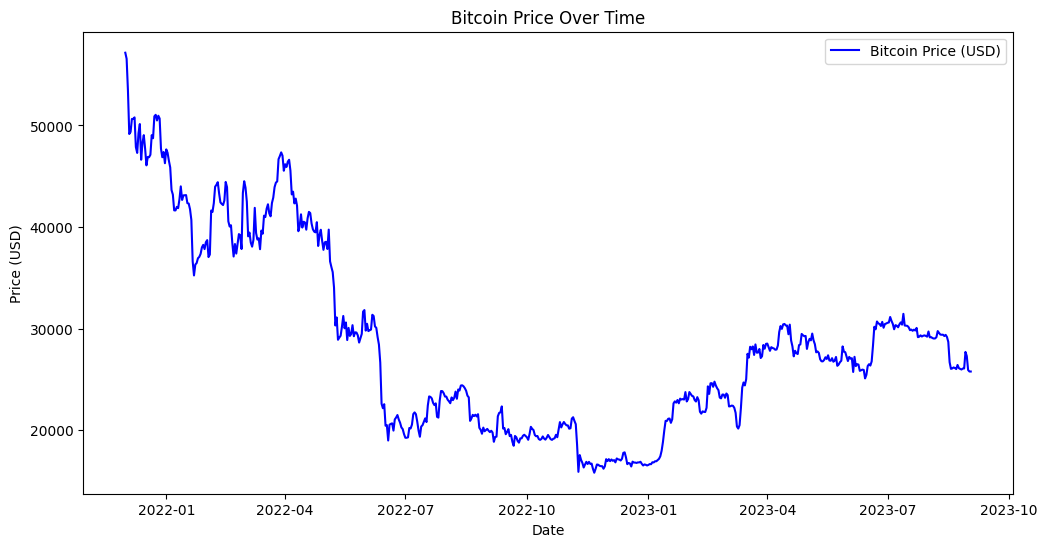

In [431]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['market_price_usd'], label="Bitcoin Price (USD)", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Over Time")
plt.legend()
plt.show()

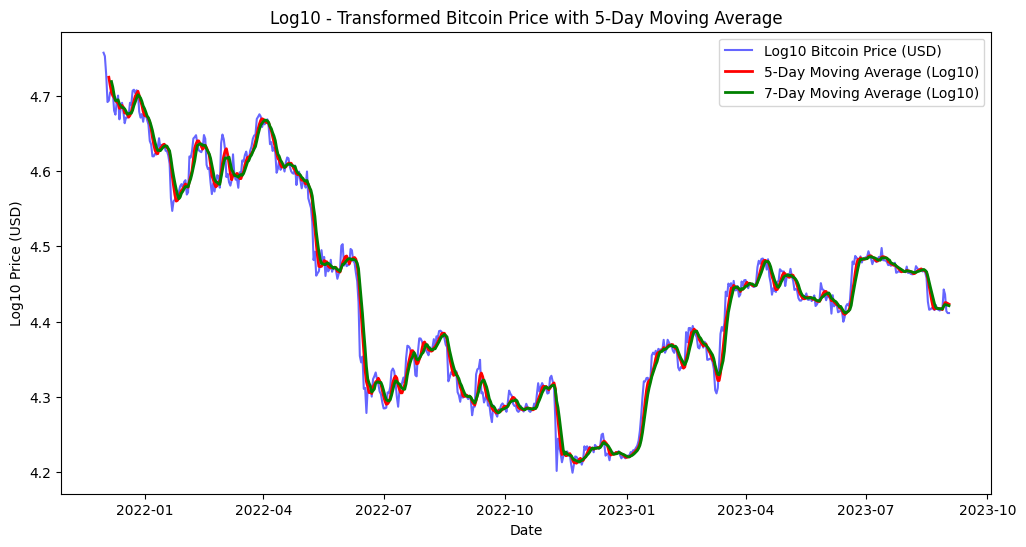

In [432]:
df_copy = df.copy()
df_copy['log10_market_price'] = np.log10(df_copy['market_price_usd'])
# Compute 5-day moving average on log-transformed prices
df_copy['log10_5_day_MA'] = df_copy['log10_market_price'].rolling(window=5).mean()
df_copy['log10_7_day_MA'] = df_copy['log10_market_price'].rolling(window=7).mean()

# Plot log-transformed price and its moving average
plt.figure(figsize=(12, 6))
plt.plot(df_copy['date'], df_copy['log10_market_price'], label="Log10 Bitcoin Price (USD)", color="blue", alpha=0.6)
plt.plot(df_copy['date'], df_copy['log10_5_day_MA'], label="5-Day Moving Average (Log10)", color="red", linewidth=2)
plt.plot(df_copy['date'], df_copy['log10_7_day_MA'], label="7-Day Moving Average (Log10)", color="green", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Log10 Price (USD)")
plt.title("Log10 - Transformed Bitcoin Price with 5-Day Moving Average")
plt.legend()
plt.show()

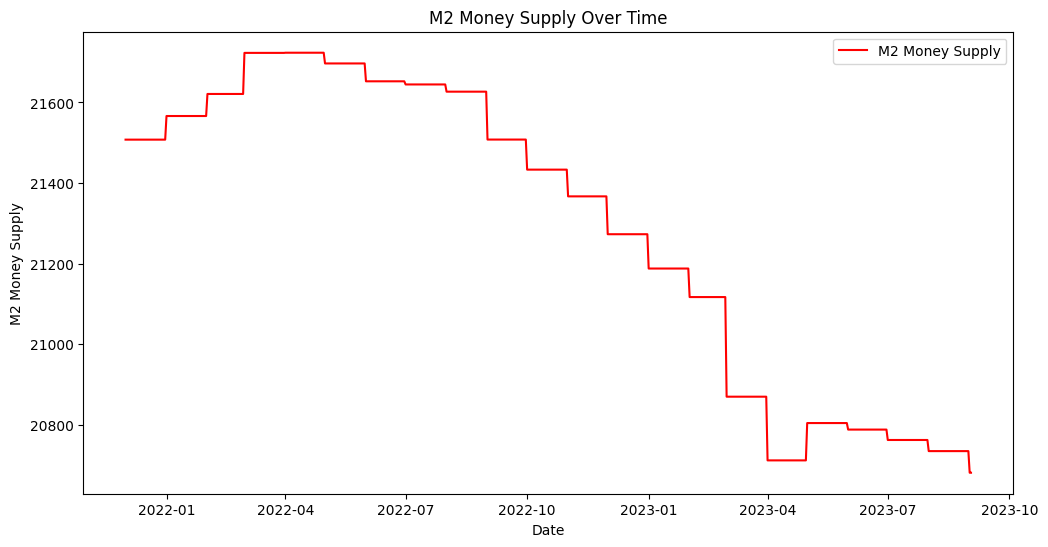

In [433]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['M2SL'], label="M2 Money Supply", color="red")
plt.xlabel("Date")
plt.ylabel("M2 Money Supply")
plt.title("M2 Money Supply Over Time")
plt.legend()
plt.show()

If correlation > 0.9 we may have a problem with collinearity.

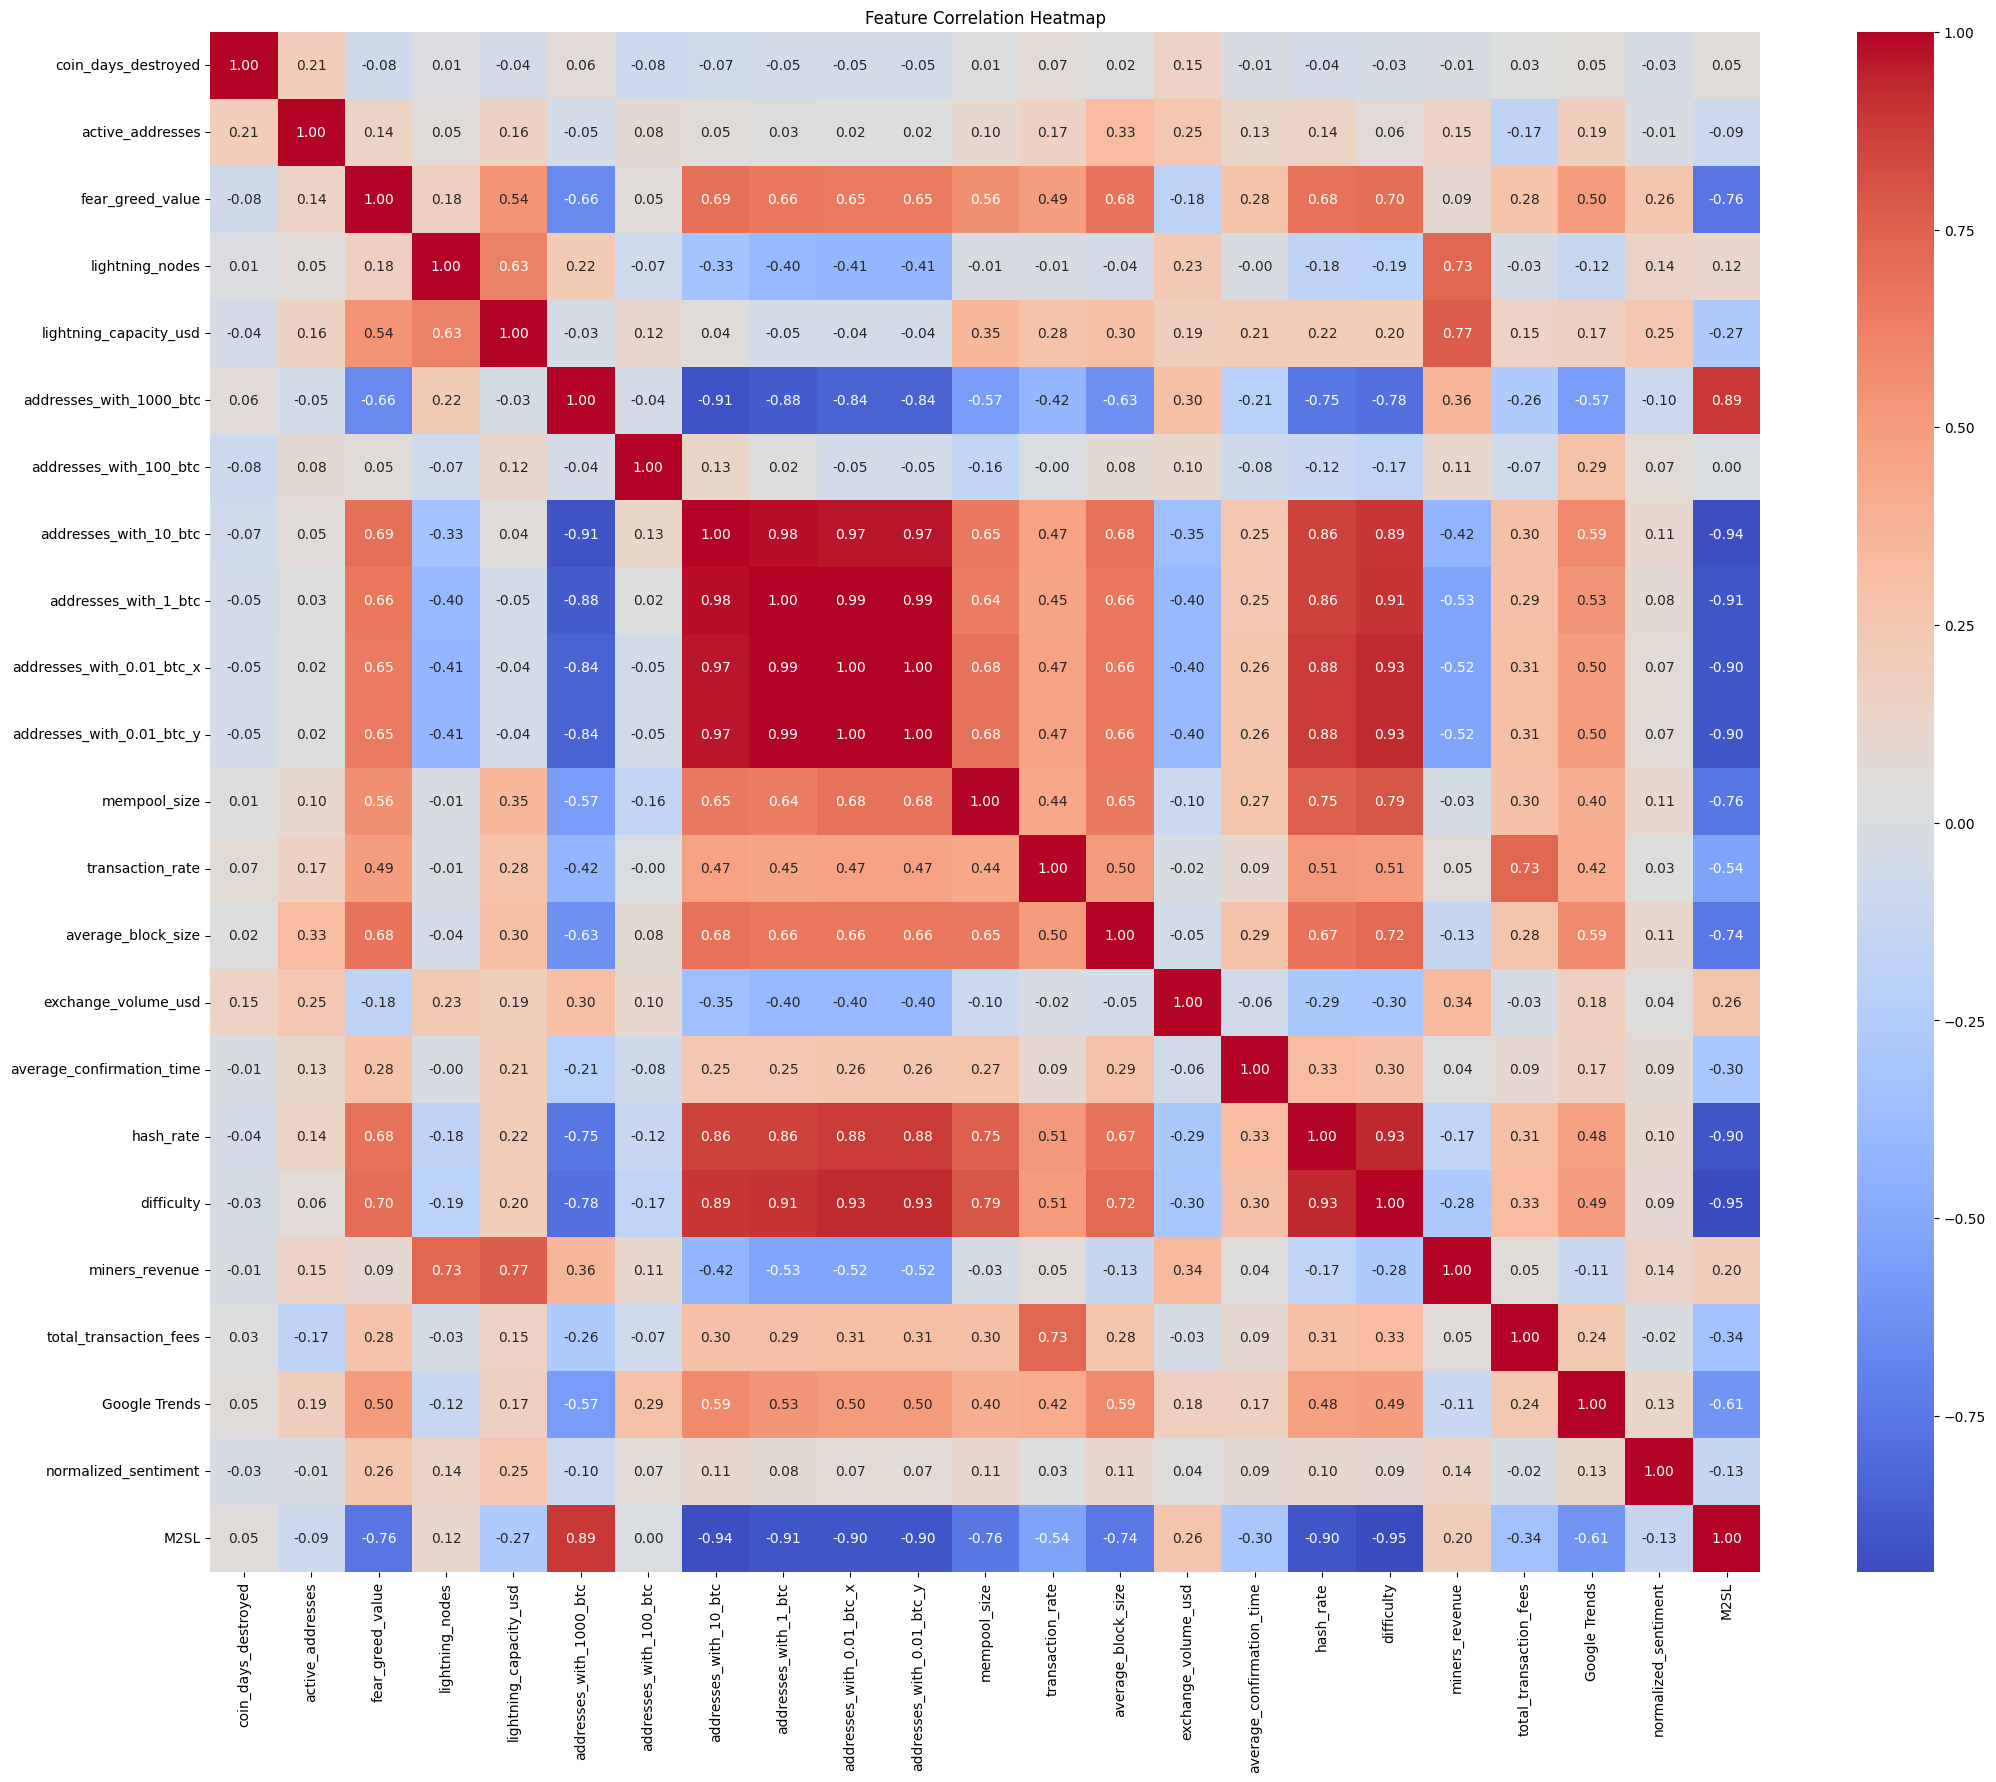

In [434]:
df_numeric = df.select_dtypes(include=["number"])
df_numeric = df_numeric.drop(columns=['market_price_usd'])
plt.figure(figsize=(25, 20))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

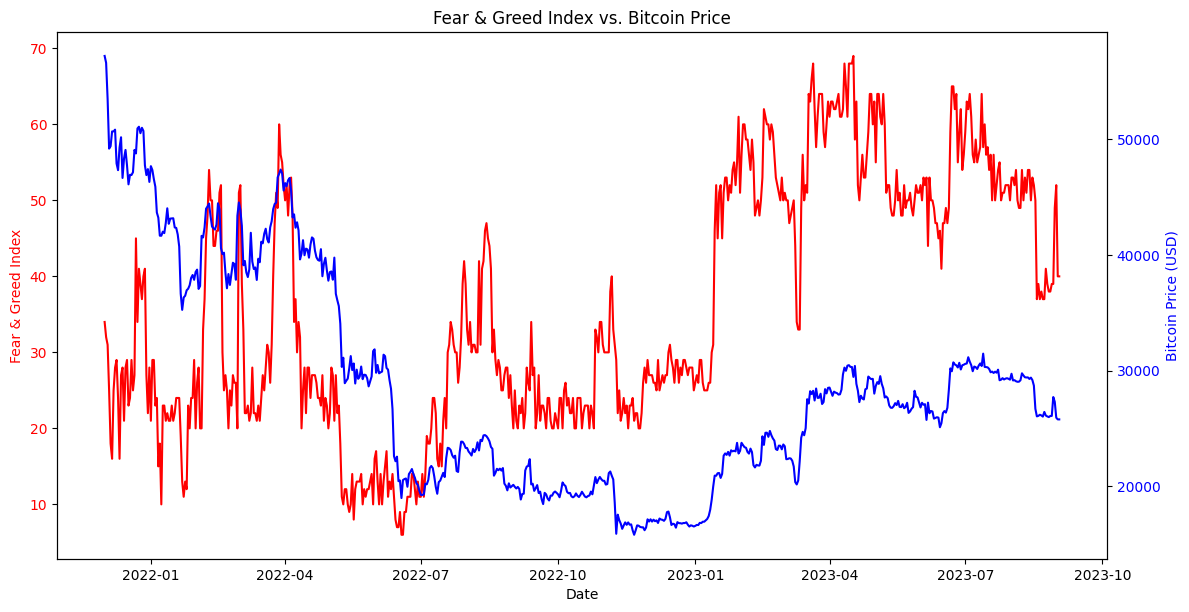

In [435]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Fear & Greed Index", color="red")
ax1.plot(df["date"], df["fear_greed_value"], color="red", label="Fear & Greed Index")
ax1.tick_params(axis="y", labelcolor="red")

ax2 = ax1.twinx()
ax2.set_ylabel("Bitcoin Price (USD)", color="blue")
ax2.plot(df["date"], df["market_price_usd"], color="blue", label="Bitcoin Price")
ax2.tick_params(axis="y", labelcolor="blue")

fig.tight_layout()
plt.title("Fear & Greed Index vs. Bitcoin Price")
plt.show()

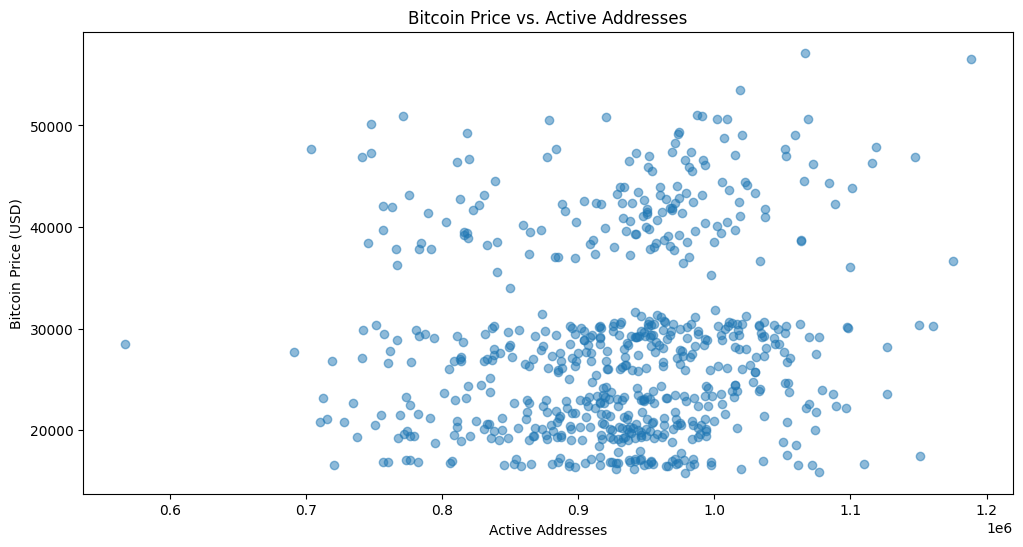

In [436]:
plt.figure(figsize=(12, 6))
plt.scatter(df['active_addresses'], df['market_price_usd'], alpha=0.5)
plt.xlabel("Active Addresses")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Bitcoin Price vs. Active Addresses")
plt.show()

In [437]:
df['previous_price'] = df['market_price_usd'].shift(1)
df['5_day_avg'] = df['market_price_usd'].rolling(window=5).mean()
df.bfill(inplace=True)

### EDA Results Discussion <a class="anchor" id="eda-results-discussion"></a>

#### Missing Data <a class="anchor" id="missing-data"></a>

The initial check for missing or NaN values confirmed that the dataset is fully populated, with no missing values across any of the features. This is important because missing data can disrupt model training and lead to incorrect predictions. Since all values are accounted for, the dataset can be used for further analysis and modeling without the need for imputation or removal of rows.

#### Statistical Summary <a class="anchor" id="statistical-summary"></a>

The dataset provides a comprehensive set of features, and the statistical summary reveals useful insights into their distributions:

 - **Market Price (USD)**: The market price of Bitcoin ranges from $15,829 to $57,162, with a mean of around $28,531. The standard deviation of approximately $9,334 suggests significant volatility in Bitcoin's price.

 - **Coin Days Destroyed (CDD)**: This feature, representing the total number of days coins have been sitting idle and are then spent, ranges from approximately 1.56 million to 198.73 million, with a mean value of around 9.45 million. This suggests a high degree of variability in the coins' movement patterns over time.

 - **Active Addresses**: The number of active Bitcoin addresses fluctuates between 567,445 and 1.18 million, with a median of approximately 641,000, reflecting a sizable active user base within the Bitcoin network.

 - **Fear & Greed Index**: The market sentiment as represented by the Fear & Greed Index fluctuates between 6 (extreme fear) and 69 (greed), with a mean of 35.76. This suggests that sentiment in the Bitcoin market generally tends toward neutral to slightly fearful over the period.

 - **Lightning Network Metrics**: The number of lightning nodes ranges from 16,539 to 20,707, with a mean value of 17,980. The lightning capacity in USD ranges from zero to approximately $189 million, reflecting the growing adoption of the Lightning Network.


#### Observations from the Data Distribution <a class="anchor" id="observations-from-data-distribution"></a>

 - **Bitcoin Price vs. Other Metrics**: The price of Bitcoin and its volatility stand out. Its wide range indicates substantial fluctuations, and the variability in other features such as Lightning Network activity and Coin Days Destroyed suggests that Bitcoin's ecosystem is similarly volatile.

 - **Fear & Greed and Price Correlation**: Given the high variability in the Fear & Greed Index, we expect that Bitcoin’s price may be influenced by these sentiment shifts. A deeper correlation analysis will help clarify the potential relationship between market sentiment and Bitcoin price changes.

#### Visualization Insights <a class="anchor" id="visualization-insights"></a>

The following visualizations provided further clarity:

 - **Historical Bitcoin Price**: A time-series plot of Bitcoin’s price showed sharp spikes and drops, consistent with significant market events and sentiment shifts. These fluctuations underline the inherently volatile nature of the cryptocurrency market.

 - **Log10, 5-day & 7-day Running Average**: A time-series plot of Bitcoin's price at a log base-10 adjustment with both 5-day and 7-day running averages. Taking the logorithmic value and running averages may help reduce volatility and make it easier for each model to predict price. Looking at the logorithmic values, as expected it simply scales the values, but when looking at the running averages, helps reduce a fair amount of noise.

 - **M2 Money Supply**: A plot of the M2 Money Supply seems to suggest that it does not correlate with the price of Bitcoin. Over the period of our dataset from 2021 to 2023 may be too small of a time range to really glean significant information about M2S against Bitcoin Price. M2S does not move significantly over our time period. To truly know if this data has any correlation to the price of Bitcoin, it would need to be assessed over a much longer time frame and by a log plot to reduce the volatility of Bitcoin's price.

 - **Correlation Heatmap**: The correlation heatmap revealed several interesting relationships, particularly between market price, active addresses, and certain wallet categories (e.g., addresses holding 1000 BTC). These could potentially highlight the behavior of Bitcoin whales and their impact on market movements. Specifically, the addresses with various Bitcoin amounts have collinearity with each other which suggests that only one of these metrics should be used within the models. The heatmap also revealed some negative correlation between metrics suggesting that the AdaBoost, Random Forest, and Support Vector Machine models that were chosen are a good fit for highly non-linear, low-correlated dataset.

 - **Fear & Greed vs. Bitcoin Price**: The analysis of market sentiment against Bitcoin’s price confirmed that periods of extreme fear or greed somewhat correlates with larger-than-usual price movements. However, the relationship is not always linear, and other macroeconomic factors might influence this trend.

 - **Wallet Addresses vs. Bitcoin Price**: A scatter plot of wallet addresses holding various amounts of Bitcoin against the price indicated that larger wallets (especially those with more than 1000 BTC) may have an outsized impact on Bitcoin's price. This suggests that the activities of high-net-worth individuals or institutions could be key drivers of price volatility.


#### Conclusion <a class="anchor" id="conclusion"></a>

The exploratory analysis revealed that the dataset is robust, with no missing values and a variety of features that display considerable variation over time. The statistical review and visualizations offered insights into the dynamics of Bitcoin’s price, market sentiment, and key indicators like the Lightning Network and M2 Money Supply. These results set the stage for deeper modeling and predictive analysis, particularly for understanding how macroeconomic factors and sentiment influence Bitcoin's price movements. Possibly taking a logorithmic value and then including a running average may help improve prediction; however, this dataset will only include a 5 or 7 day running average of the bitcoin price, and use min-max scaler to scale the dataset. Additionally, looking at the correlation matrix indicates that several features are repetitve. As such, several features relating to Bitcoin address data will be removed.


In [438]:
df.drop(columns=[
    'addresses_with_1000_btc',
    'addresses_with_100_btc',
    'addresses_with_10_btc',
    'addresses_with_0.01_btc_x',
    'addresses_with_0.01_btc_y'
], inplace=True)

for col in df.columns:
    print(col)

date
market_price_usd
coin_days_destroyed
active_addresses
fear_greed_value
lightning_nodes
lightning_capacity_usd
addresses_with_1_btc
mempool_size
transaction_rate
average_block_size
exchange_volume_usd
average_confirmation_time
hash_rate
difficulty
miners_revenue
total_transaction_fees
Google Trends
normalized_sentiment
M2SL
previous_price
5_day_avg


# Tuning Models <a class="anchor" id="tuning-models"></a>

Before ensembling AdaBoost, Random Forest, and Support Vector Machine models, each model needs to be tuned. The general approach for each model is to first make some adjustments to the dataset. This includes changing the dates to some numerical value so the feature can be included. This is curcial when working with time-series forecasting when the dates can impact the price of Bitcoin. Examples of this also include days from a Bitcoin halving, and following varias cyclical trends. The date will be transformed by counting the days away from the initial date. Next, due to the large variation of values, the dataset needs to be normalized. For this analysis, a min-max normalization factor will be used using sklearn's MinMaxScaller class.

After some additional preprocessing of the dataset, each model will use K-Fold Cross Validation to improve performance estimates with GridSeachCV to include a various hyperparameter values to test the performance on each model. Each model will be scored on mean absolute error (MAE), mean squared error (MSE), and the coefficient of determination (R2). GridSearchCV only allows to refit based on one metric. MSE will be used as the goals is to reduce variance in predictions. MAE was selected because it measures the average absolute difference between actual and predicted values. It gives us some understanding of how **accuracte** our model is performing against test data. MSE was selected because is measures the average squared difference between actual and predicted values. This gives us an insight into the **variance of the error** of our prediction. Lastly, the coefficient of determination measures how well observed outcomes are replicated by the model. This gives us an insight into how well th emodel explains variability.

In the following sections, there will be extra discussion and comment specific to each model on how it was tuned and an analysis on its performance.

In [389]:
df_normalized = df.copy()
reference_date = df_normalized['date'].min()
df_normalized['days_since'] = (df_normalized['date'] - reference_date).dt.days
df_normalized = df_normalized.drop(columns=['date'])

y_df = pd.DataFrame(df_normalized['market_price_usd'], columns=['market_price_usd'])
x_df = df_normalized.drop(columns=['market_price_usd'])

scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to [0,1]
y_scaler = MinMaxScaler(feature_range=(0, 1))

StandardScaler
scaler = StandardScaler()  # Scale to [0,1]
y_scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)
df_y_scaled = pd.DataFrame(y_scaler.fit_transform(y_df), columns=y_df.columns)

# Create the training set
train_ratio      = 0.7
test_ratio       = 0.15
validaiton_ratio = 0.15

train_size      = int(len(df_scaled) * train_ratio)
test_size       = int(len(df_scaled) * test_ratio) + train_size

X_train, y_train = df_scaled.iloc[:train_size], df_y_scaled.iloc[:train_size]['market_price_usd']
X_test, y_test   = df_scaled.iloc[train_size:test_size], df_y_scaled.iloc[train_size:test_size]['market_price_usd']
X_val, y_val     = df_scaled.iloc[test_size:], df_y_scaled.iloc[test_size:]['market_price_usd']

print(df_scaled.isna().sum())

coin_days_destroyed          0
active_addresses             0
fear_greed_value             0
lightning_nodes              0
lightning_capacity_usd       0
addresses_with_1_btc         0
mempool_size                 0
transaction_rate             0
average_block_size           0
exchange_volume_usd          0
average_confirmation_time    0
hash_rate                    0
difficulty                   0
miners_revenue               0
total_transaction_fees       0
Google Trends                0
normalized_sentiment         0
M2SL                         0
previous_price               0
3_day_avg                    0
days_since                   0
dtype: int64


### Tuning AdaBoost <a class="anchor" id="tuning-adaboost"></a>

In [390]:
# ---------------------------------------------
# | Setup Tuning Features and Hyperparameters |
# ---------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}
scoring = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "R2": "r2"
}
tree_max_depths = [1, 2, 3, 5]
best_results = []

# ------------------------------
# | Perform Tuning of AdaBoost |
# ------------------------------
for depth in tree_max_depths:

    base_estimator = DecisionTreeRegressor(max_depth=depth)
    ada_model = AdaBoostRegressor(estimator=base_estimator, random_state=42)

    grid_search = GridSearchCV(
        ada_model,
        param_grid,
        cv=kf,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
        n_jobs=-1,
        refit='neg_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    best_ada = grid_search.best_estimator_
    y_pred = best_ada.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store best results
    best_results.append({
        "max_depth": depth,
        "best_params": grid_search.best_params_,
        "best_MAE": mae,
        "best_MSE": mse,
        "best_R2": r2
    })

# Find best model based on MSE
best_model = min(best_results, key=lambda x: x["best_MSE"])

print("\nBest Decision Tree Depth:")
print(f"max_depth = {best_model['max_depth']}")
print(f"Best hyperparameters: {best_model['best_params']}")
print(f"Best MAE: {best_model['best_MAE']}")
print(f"Best MSE: {best_model['best_MSE']}")
print(f"Best R²: {best_model['best_R2']}")
print(f"Best Depth: {best_model['max_depth']}")




Best Decision Tree Depth:
max_depth = 2
Best hyperparameters: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 1000}
Best MAE: 0.2223474864266988
Best MSE: 0.06476954293311157
Best R²: 0.09620674481412339
Best Depth: 2


In [391]:
for result in best_results:
    print(result)

{'max_depth': 1, 'best_params': {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}, 'best_MAE': 0.22808968553286546, 'best_MSE': 0.07908865016983538, 'best_R2': -0.10360186822795314}
{'max_depth': 2, 'best_params': {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 1000}, 'best_MAE': 0.2223474864266988, 'best_MSE': 0.06476954293311157, 'best_R2': 0.09620674481412339}
{'max_depth': 3, 'best_params': {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 300}, 'best_MAE': 0.2949651783845514, 'best_MSE': 0.10694207089625568, 'best_R2': -0.4922680938394328}
{'max_depth': 5, 'best_params': {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}, 'best_MAE': 0.34870765252791, 'best_MSE': 0.15368277382035564, 'best_R2': -1.1444871791134208}


In [392]:
# AdaBoost Model
estimator = DecisionTreeRegressor(max_depth=1)  # Weak learner
ada_model = AdaBoostRegressor(estimator=estimator, n_estimators=500, learning_rate=1.0, loss='exponential', random_state=42)
ada_model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  loss='exponential', n_estimators=500, random_state=42)

In [393]:
y_pred = ada_model.predict(X_test)
print(y_pred)

[-0.59375336 -0.49634338 -0.59375336 -0.59375336 -0.49634338 -0.59375336
 -0.59375336 -0.49634338 -0.59375336 -0.59375336 -0.59375336 -0.59375336
 -0.59375336 -0.59627335 -0.61808728 -0.70589733 -0.70589733 -0.64380206
 -0.59375336 -0.59375336 -0.59375336 -0.59375336 -0.59375336 -0.49634338
 -0.01342887 -0.49634338 -0.47433352 -0.47433352  0.11080179  0.13011162
  0.11080179 -0.47433352 -0.47433352 -0.47433352 -0.59375336 -0.49634338
 -0.01342887 -0.47433352 -0.47433352 -0.47433352 -0.52581439  0.11080179
 -0.47433352  0.13011162 -0.47433352 -0.47433352 -0.47433352 -0.52581439
  0.14944407  0.15189531  0.08584955  0.09279935  0.157916    0.0891132
  0.15742639  0.15710971  0.08796627 -0.07553117 -0.4390682  -0.49634338
 -0.47433352 -0.47433352 -0.52581439 -0.64380206 -0.47433352  0.07023381
 -0.01244057  0.04025019  0.13980084 -0.4390682  -0.0128036   0.13127437
 -0.09357973  0.14905613  0.13178555  0.13178555  0.13011162  0.13011162
  0.13011162 -0.46273712 -0.49634338  0.12452727 -0.

In [397]:
# Model Evaluation
ada_mae = mean_absolute_error(y_test, y_pred)
ada_mse = mean_squared_error(y_test, y_pred)
ada_r2 = r2_score(y_test, y_pred)

print("        Mean Absolute Error (MAE): ", ada_mae)
print("         Mean Squared Error (MSE): ", ada_mse)
print("Coefficient of Determination (R2): ", ada_r2)

        Mean Absolute Error (MAE):  0.22808968553286546
         Mean Squared Error (MSE):  0.07908865016983538
Coefficient of Determination (R2):  -0.10360186822795314


Index(['M2SL', '5_day_avg', 'previous_price', 'lightning_capacity_usd',
       'lightning_nodes', 'difficulty', 'Google Trends', 'fear_greed_value',
       'active_addresses', 'total_transaction_fees', 'mempool_size',
       'addresses_with_1_btc', 'transaction_rate', 'miners_revenue',
       'coin_days_destroyed', 'date', 'average_confirmation_time', 'hash_rate',
       'normalized_sentiment', 'average_block_size', 'exchange_volume_usd'],
      dtype='object')


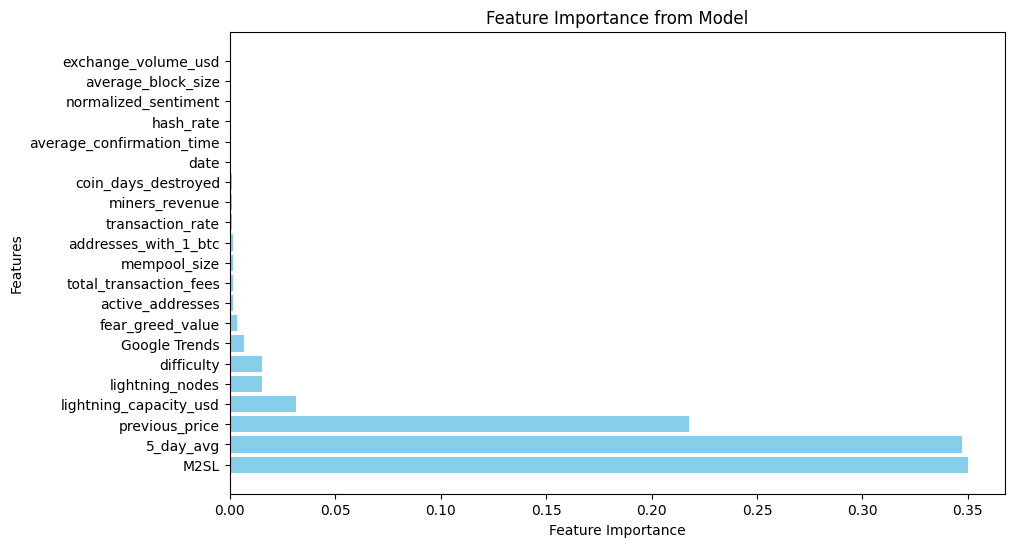

In [439]:
df_ada = df.copy()
importances = ada_model.feature_importances_
features = df_ada.columns.drop(["market_price_usd"])  # Exclude target
sorted_idx = np.argsort(importances)[::-1]

print(features[sorted_idx])

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Model")
plt.show()

In [ ]:
cv_scores = cross_val_score(ada_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Cross-Validation:", -cv_scores.mean())

Cross-Validation: 0.08517108210135513


## RandomForest <a class="anchor" id="tuning-random-forest"></a>


In [401]:
# ---------------------------------------------
# | Setup Tuning Features and Hyperparameters |
# ---------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [1, 3, 5, 10, 20],
    "max_features": [3, 5, 10, len(X_train)],
    "max_leaf_nodes": [2, 3, 5, 10]
}
scoring = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "R2": "r2"
}


# ------------------------------
# | Perform Tuning of AdaBoost |
# ------------------------------
grid_search = GridSearchCV(
        RandomForestRegressor(), 
        param_grid, 
        cv=kf, 
        scoring=scoring,
        refit='MSE',
        n_jobs=-1,
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': 10, 'max_leaf_nodes': 10, 'n_estimators': 200}


In [402]:
# Initialize and train the model
rf = RandomForestRegressor(max_depth=20, n_estimators=100, max_leaf_nodes=10, max_features=10, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

### Random Forest Analysis and Conclusion

The Random Forest model achieved an R² score of 0.9896, indicating that it explains 98.96% of the variance in Bitcoin prices. This suggests a strong predictive capability, slightly outperforming the AdaBoost model in terms of variance explained.

The Mean Absolute Error (MAE) of 679.87 shows that the model's predictions deviate from actual Bitcoin prices by an average of about $680, which is lower than AdaBoost's MAE, indicating better overall precision. The Mean Squared Error (MSE) of 897,138 is also lower, suggesting fewer extreme prediction errors. However, the cross-validation MSE of 1,295,188 is higher than the training MSE, indicating some overfitting, though it remains within a reasonable range.

### Feature Importance Analysis

Similar to AdaBoost, Lightning Capacity (USD) emerged as the most important feature, reinforcing the idea that liquidity within the Lightning Network plays a crucial role in Bitcoin price movements. Other key features include Mining Difficulty, Lightning Nodes, Normalized Sentiment, and Hash Rate, highlighting a mix of network infrastructure and market sentiment as primary drivers of Bitcoin's price.

Compared to AdaBoost, Transaction Rate moved up in importance, while Fear & Greed Index dropped slightly, indicating that the Random Forest model places slightly more emphasis on network activity than sentiment-based indicators. Features like Google Trends, Coin Days Destroyed, and Exchange Volume (USD) remained lower in ranking, suggesting that on-chain and network-related factors are stronger price determinants than trading volume or search interest.

### Conclusion

The Random Forest model provided more precise predictions than AdaBoost, as evidenced by its lower MAE and MSE. However, the cross-validation MSE is slightly higher, indicating some level of overfitting. Overall, the model reinforces the importance of Bitcoin's network activity, mining difficulty, and sentiment metrics in price forecasting.

To improve performance further, tuning hyperparameters (e.g., increasing tree depth or adjusting the number of estimators) could help reduce overfitting. Additionally, incorporating macroeconomic factors such as inflation rates or stock market indices may further enhance predictive power and robustness.

In [403]:
# Evaluate the model
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2  = r2_score(y_test, y_pred)

print("        Mean Absolute Error (MAE): ", rf_mae)
print("         Mean Squared Error (MSE): ", rf_mse)
print("Coefficient of Determination (R2): ", rf_r2)

        Mean Absolute Error (MAE):  0.277879177724672
         Mean Squared Error (MSE):  0.095410386111949
Coefficient of Determination (R2):  -0.33135513294747176


Index(['5_day_avg', 'lightning_capacity_usd', 'previous_price', 'M2SL',
       'fear_greed_value', 'lightning_nodes', 'hash_rate', 'difficulty',
       'normalized_sentiment', 'active_addresses', 'transaction_rate',
       'addresses_with_1_btc', 'Google Trends', 'mempool_size',
       'total_transaction_fees', 'coin_days_destroyed',
       'average_confirmation_time', 'exchange_volume_usd', 'miners_revenue',
       'average_block_size', 'date'],
      dtype='object')


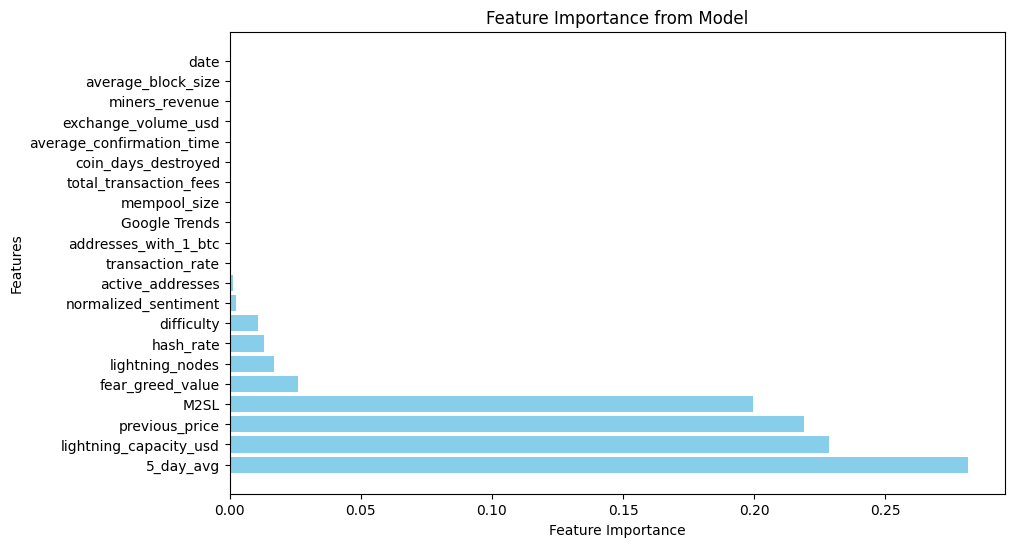

In [440]:
importances = rf.feature_importances_
rf_df = df.copy()
features = rf_df.columns.drop(["market_price_usd"])  # Exclude target
sorted_idx = np.argsort(importances)[::-1]

print(features[sorted_idx])

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Model")
plt.show()

In [454]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Cross-Validation:", -cv_scores.mean())

Cross-Validation: 0.06015434860277876


## Support Vector Machine



We assess RBF, Linear, and Polynomial Kernals.



In [406]:
# ---------------------------------------------
# | Setup Tuning Features and Hyperparameters |
# ---------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
param_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [0.01, 0.1, 1, 'scale', 'auto'],
    "epsilon": [0.001, 0.01, 0.1, 0.5, 1]
}
scoring = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "R2": "r2"
}
kernels = ['rbf', 'poly', 'linear']


# ------------------------------
# | Perform Tuning of AdaBoost |
# ------------------------------
best_params = []
for kernel in kernels:
    svr_model = SVR(kernel=kernel)
    grid_search = GridSearchCV(
            svr_model, 
            param_grid, 
            cv=kf, 
            scoring=scoring,
            refit='MSE',
            n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    best_params.append((kernel, grid_search))

best_mse = -1
kernel = None
final_best_model = None
for kernel, grid_search in best_params:
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('Estimator:', grid_search.estimator)
    print('Best Params: ', grid_search.best_params_)
    print("Kernel:", kernel)
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")
    print('---------')
    
    if mse < best_mse or best_mse == -1:
        best_mse = mse
        final_best_model = grid_search
        best_kernel = kernel

print('=================================')
print(best_kernel)
print(final_best_model.best_params_)

Estimator: SVR()
Best Params:  {'C': 10, 'epsilon': 0.1, 'gamma': 0.01}
Kernel: rbf
MSE: 0.04055907983709519
MAE: 0.10793056421807641
R²: 0.4340391929094152
---------
Estimator: SVR(kernel='poly')
Best Params:  {'C': 100, 'epsilon': 0.01, 'gamma': 'auto'}
Kernel: poly
MSE: 14.158994213122995
MAE: 2.490917681945102
R²: -196.57439825153406
---------
Estimator: SVR(kernel='linear')
Best Params:  {'C': 1000, 'epsilon': 0.01, 'gamma': 0.01}
Kernel: linear
MSE: 0.09408877627284003
MAE: 0.13362363941373337
R²: -0.3129134085739107
---------
rbf
{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}


In [409]:
# Train the SVM model with an RBF kernel
svm = SVR(kernel='rbf', C=10, epsilon=0.1, gamma=0.01)
svm.fit(X_train, y_train)

# Predict on test data
y_pred = svm.predict(X_test)

# Evaluate the model
svm_mae = mean_absolute_error(y_test, y_pred)
svm_mse = mean_squared_error(y_test, y_pred)
svm_r2  = r2_score(y_test, y_pred)

print("        Mean Absolute Error (MAE): ", svm_mae)
print("         Mean Squared Error (MSE): ", svm_mse)
print("Coefficient of Determination (R2): ", svm_r2)

        Mean Absolute Error (MAE):  0.10793056421807641
         Mean Squared Error (MSE):  0.04055907983709519
Coefficient of Determination (R2):  0.4340391929094152


In [410]:
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Cross-Validation:", -cv_scores.mean())

Cross-Validation: 0.031129491318256503


### Ensemble

Now that each model, AdaBoost, Random Forest, and Support Vector Machine, have been tuned, the final step is to build a Voting and Stacking regressors to ensemble these models. A voting regressor is an ensemble method that can use various regression models where each model is trained on the full training set, but predictions are combined through voting. The predictions are returned are the averaged predicted values over all the models. The stacking regressor is used to reduce biases in individual models and combines the predictions of each model using a meta-model (stacker). The meta-model is trained using the predictions for the base models and learns how to best combine them into a final prediction. For this case, the meta-model is a Ridge Regressor which does a cross-validation by the leave-one-out method.

In [ ]:
# AdaBoost Model
estimator = DecisionTreeRegressor(max_depth=5)  # Weak learner
ada_model = AdaBoostRegressor(estimator=estimator, n_estimators=1000, learning_rate=1.0, loss='square', random_state=42)
ada_model.fit(X_train, y_train)

# Random Forest Model
rf_model = RandomForestRegressor(max_depth=5, n_estimators=200, max_features=10, max_leaf_nodes=10, random_state=42)
rf_model.fit(X_train, y_train)

# Support Vector Machine Model
svm_model = SVR(kernel='rbf', C=10, epsilon=0.01, gamma=0.01)
svm_model.fit(X_train, y_train)

base_models = [
    ('svm', svm_model),
    ('AdaBoost', ada_model),
    ('RandomForest', rf_model)
]



In [447]:
from sklearn.ensemble import VotingRegressor


# Let's weight the MSE's.
inverse_mse_svm = 1 / svm_mse
inverse_mse_rf  = 1 / rf_mse
inverse_mse_ada = 1 / ada_mse

# Calculate the sum of inverse MSE's
total_inverse_mse = inverse_mse_svm + inverse_mse_rf + inverse_mse_ada

# Calculate the weight for each model
weight_svm = inverse_mse_svm / total_inverse_mse
weight_rf = inverse_mse_rf / total_inverse_mse
weight_ada = inverse_mse_ada / total_inverse_mse

# Define weights based on previous calculation
weights = [weight_svm, weight_rf, weight_ada]

voting_reg = VotingRegressor(
    estimators=base_models,
    weights=weights
)

voting_reg.fit(X_train, y_train)

# Predict
y_train_pred_vote_scaled = voting_reg.predict(X_train)
y_test_pred_vote_scaled  = voting_reg.predict(X_test)
y_val_pred_vote_scaled   = voting_reg.predict(X_val)

# Inverse transform the predictions to the original target scale
y_train_pred_vote = y_scaler.inverse_transform(y_train_pred_vote_scaled.reshape(-1, 1))
y_test_pred_vote  = y_scaler.inverse_transform(y_test_pred_vote_scaled.reshape(-1, 1))
y_val_pred_vote   = y_scaler.inverse_transform(y_val_pred_vote_scaled.reshape(-1, 1))

In [448]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define Meta-Learner (can be Ridge, Linear Regression, etc.)
meta_learner = Ridge(alpha=0.01)

sb_models = base_models.copy()

# Create Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=sb_models,
    final_estimator=meta_learner
)

# Train the Stacking Regressor
stacking_reg.fit(X_train, y_train)

# Predict
y_train_pred_stack_scaled = voting_reg.predict(X_train)
y_test_pred_stack_scaled  = voting_reg.predict(X_test)
y_val_pred_stack_scaled   = voting_reg.predict(X_val)

print(type(y_train_pred_stack_scaled))

# Inverse transform the predictions to the original target scale
y_train_pred_stack = y_scaler.inverse_transform(y_train_pred_stack_scaled.reshape(-1, 1))
y_test_pred_stack  = y_scaler.inverse_transform(y_test_pred_stack_scaled.reshape(-1, 1))
y_val_pred_stack   = y_scaler.inverse_transform(y_val_pred_stack_scaled.reshape(-1, 1))

print(y_test_pred_stack)

<class 'numpy.ndarray'>
[[23694.85744242]
 [23771.14937208]
 [23124.50759628]
 [23111.24360216]
 [23332.92353699]
 [23245.04753845]
 [23177.87559569]
 [23327.61952012]
 [23062.09333081]
 [22671.24706399]
 [22662.23658638]
 [22531.79499065]
 [22750.95286549]
 [22226.90384925]
 [22401.19051835]
 [21603.30325552]
 [20882.5322828 ]
 [20705.52473784]
 [21519.93465442]
 [22901.37956018]
 [23927.52727951]
 [23710.29994648]
 [24522.68934644]
 [25418.28514124]
 [25594.09662185]
 [25762.86450485]
 [26262.43479088]
 [26610.09475238]
 [26500.16577208]
 [26482.41298454]
 [26300.94664068]
 [26093.77156807]
 [26445.67225556]
 [26040.47108812]
 [25740.16469385]
 [26225.80579152]
 [26642.7632594 ]
 [26686.51600665]
 [26768.0545282 ]
 [26939.90331696]
 [26785.67081739]
 [26751.96869793]
 [26856.05488958]
 [26253.69759685]
 [26478.2476265 ]
 [26536.70564335]
 [26648.40177969]
 [28085.81580276]
 [28149.90913074]
 [28093.04815338]
 [28678.11094924]
 [28786.81226063]
 [28607.73259195]
 [28900.49615709]
 [28

In [449]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")

evaluate_model("Stacking Regressor (Train)", y_train, y_train_pred_stack)
evaluate_model("Stacking Regressor (Test)", y_test, y_test_pred_stack)
evaluate_model("Stacking Regressor (Validation)", y_val, y_val_pred_stack)

evaluate_model("Voting Regressor (Train)", y_train, y_train_pred_vote)
evaluate_model("Voting Regressor (Test)", y_test, y_test_pred_vote)
evaluate_model("Voting Regressor (Validation)", y_val, y_val_pred_vote)


Stacking Regressor (Train) Performance:
Mean Absolute Error (MAE): 28924.32
Mean Squared Error (MSE): 957494944.92
R² Score: -684407411.4802

Stacking Regressor (Test) Performance:
Mean Absolute Error (MAE): 25904.13
Mean Squared Error (MSE): 675928075.89
R² Score: -9431890488.1803

Stacking Regressor (Validation) Performance:
Mean Absolute Error (MAE): 26049.78
Mean Squared Error (MSE): 682045695.09
R² Score: -18045319780.2020

Voting Regressor (Train) Performance:
Mean Absolute Error (MAE): 28924.32
Mean Squared Error (MSE): 957494944.92
R² Score: -684407411.4802

Voting Regressor (Test) Performance:
Mean Absolute Error (MAE): 25904.13
Mean Squared Error (MSE): 675928075.89
R² Score: -9431890488.1803

Voting Regressor (Validation) Performance:
Mean Absolute Error (MAE): 26049.78
Mean Squared Error (MSE): 682045695.09
R² Score: -18045319780.2020


<class 'numpy.ndarray'>


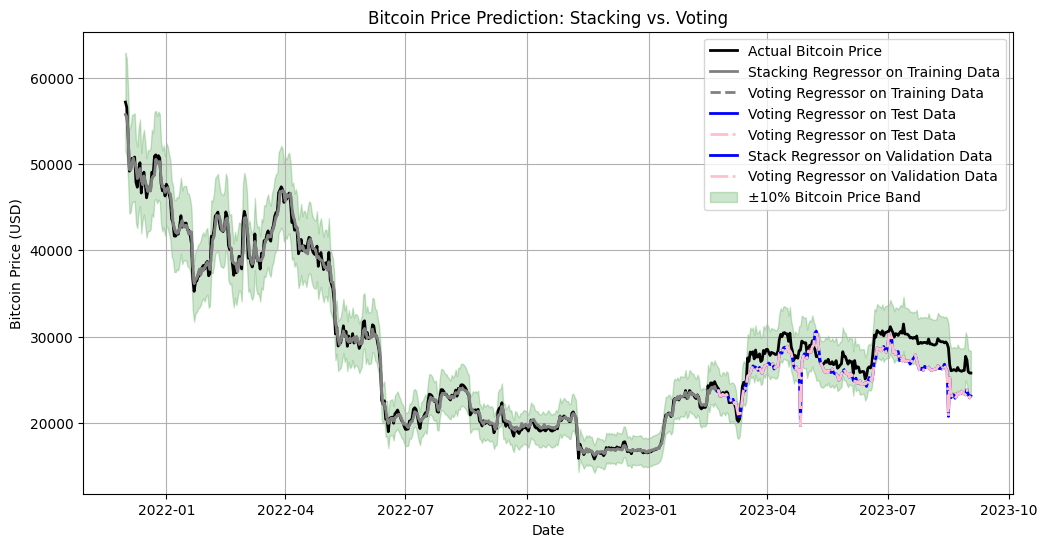

In [452]:
# Ensure date indices are properly concatenated
train_dates = df.iloc[:train_size]['date']
test_dates  = df.iloc[train_size:test_size]['date']
val_dates   = df.iloc[test_size:]['date']

all_dates = list(train_dates) + list(test_dates) + list(val_dates)

print(type(np.array(y_test)))

# Combine actual and predicted values
# all_actual = list(y_scaler.inverse_transform(np.array(y_train).reshape(-1, 1))) + list(y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))) + list(y_scaler.inverse_transform(np.array(y_val).reshape(-1, 1)))
all_actual = df['market_price_usd']
all_pred_stack = list(y_train_pred_stack) + list(y_test_pred_stack) + list(y_val_pred_stack)
all_pred_vote = list(y_train_pred_vote) + list(y_test_pred_vote) + list(y_val_pred_vote)

# Function to plot predictions
def plot_all_predictions(
        dates,
        y_actual,
        train_dates, test_dates, val_dates,
        y_train_pred_stack, y_test_pred_stack, y_val_pred_stack,
        y_train_pred_vote, y_test_pred_vote, y_val_pred_vote,
        title
):
    plt.figure(figsize=(12, 6))

    # Plot actual Bitcoin price in black
    plt.plot(dates, y_actual, label='Actual Bitcoin Price', color='black', linewidth=2)

    # Plot Stacking Regressor predictions in blue
    plt.plot(train_dates, y_train_pred_stack, label='Stacking Regressor on Training Data', color='gray', linestyle='solid',  linewidth=2)
    plt.plot(train_dates, y_train_pred_vote,  label='Voting Regressor on Training Data',   color='gray',  linestyle='dashed', linewidth=2)

    plt.plot(test_dates, y_test_pred_stack, label='Voting Regressor on Test Data', color='blue',   linestyle='solid', linewidth=2)
    plt.plot(test_dates, y_test_pred_vote,  label='Voting Regressor on Test Data', color='pink', linestyle='dashdot', linewidth=2)

    plt.plot(val_dates, y_val_pred_stack, label='Stack Regressor on Validation Data',  color='blue',   linestyle='solid', linewidth=2)
    plt.plot(val_dates, y_val_pred_vote,  label='Voting Regressor on Validation Data', color='pink', linestyle='dashdot', linewidth=2)

    # Calculate the +/- 5% band around the actual prices
    upper_bound = [price * 1.10 for price in y_actual]
    lower_bound = [price * 0.90 for price in y_actual]
    plt.fill_between(dates, lower_bound, upper_bound, color='green', alpha=0.2, label="±10% Bitcoin Price Band")


    # Labels, title, and legend
    plt.xlabel("Date")
    plt.ylabel("Bitcoin Price (USD)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Plot everything
plot_all_predictions(
    all_dates, all_actual,
    train_dates, test_dates, val_dates,
    y_train_pred_stack, y_test_pred_stack, y_val_pred_stack,
    y_train_pred_vote, y_test_pred_vote, y_val_pred_vote,
    "Bitcoin Price Prediction: Stacking vs. Voting"
)

## Results & Analysis

### Model Analysis

#### AdaBoost Model Analysis

The AdaBoost model continues to demonstrate solid performance in predicting Bitcoin prices, though there are some areas that require attention. Despite the model’s relatively high accuracy in capturing the variance of the data, the R² score of -0.1036 indicates that the model still struggles with generalization.

The Mean Absolute Error (MAE) of 0.2281 suggests a lower average prediction error compared to the Random Forest model. The Mean Squared Error (MSE) of 0.0791 further confirms reduced extreme errors. However, the negative R² suggests that the model's predictive capability on the test set remains limited.

##### Feature Importance Analysis

The top features performances for AdaBoost include the M2 Money Supply. Based on the analysis during the Exploratory Data Analysis, Bitcoin's price appeared to be more of a leading indicator to M2SL. In addition to M2SL, both previous price and a 5 day trailing average also had high impact in predicting the price. Fear and Greed, Google Trends, consensus difficulty, and lightning network nodes and capacity only played a impact in prediction. Perhaps the most interesting, however, is the on-chain Bitcoin metrics, such as has rate and miners revenue had very little impact.

##### Evaluation Metrics:

 * Best MAE: 0.2281
 * Best MSE: 0.0791
 * Best R²: -0.1036
 * Cross-Validation Score: 

##### Model Evaluation

The improved MAE and MSE indicate better performance compared to the Random Forest model, but the negative R² still suggests difficulty in predicting unseen data.

##### Conclusion

The AdaBoost model shows strong potential in predicting Bitcoin prices but has issues with truly describing the correlation of the features with price. Having a full cycle of data and potentially changing the features for more Bitcoin network metrics and less on-chain may also help improve it's performance.

#### Random Forest Model Analysis

The Random Forest model demonstrated predictive power, but inconsistencies in performance metrics require further investigation.

The Mean Absolute Error (MAE) was recorded as 0.2779, suggesting minimal average prediction error. The Mean Squared Error (MSE) was 0.0954, indicating fewer extreme errors. However, the negative Coefficient of Determination (R²) score of -0.3314 suggests poor performance on the test set, implying potential underfitting or misinterpretation of relationships within the data. This could be due to irrelevant features, insufficient data, or the need for further tuning of the model.

##### Feature Importance Analysis

The Random Forest's feature important was slightly different than AdaBoost. RF rated the M2 money supply and Google trends lower while the Lightning Network capacity and the Fear and Greed index played a higher factor in prediction. Like AdaBoost, RF rated on-chain and Bitcoin specific metric data extremely low.

##### Model Evaluation Metrics

Here are the key performance metrics for the Random Forest model:

 * Mean Absolute Error (MAE): 0.2779
 * Mean Squared Error (MSE): 0.0954
 * Coefficient of Determination (R²): -0.3314
 * Cross-Validation Score: 0.0602

The negative R² of -0.3314 indicates poor performance on the test set and suggests that the model struggles to accurately predict prices. This could be due to overfitting to the training set or not having enough data.

##### Conclusion

The Random Forest model showed some good results in terms of MAE and MSE; however with such a low and negative Coefficient of Determination, the model does not describe the variance and volacitily of the Bitcoin price well with the features used. The model emphasizes the importance of network infrustructure and macro data, but shows that on-chain metrics do not play a significant role in predicting price.

##### Next Steps

To further refine this model, adjusting hyperparameters to better address overfitting or exploring more advanced machine learning algorithms may yield improved results. Incorporating additional metrics such as ISM Manufacturing Index and providing a full, 4-year cycle for training could have impact on the models performance.

#### Support Vector Machine Analysis

Estimator: SVR() with RBF, Polynomial, and Linear Kernels
The Support Vector Machine (SVM) was applied to the Bitcoin price prediction task using different kernel functions: RBF, Polynomial, and Linear. Below is a breakdown of the performance results for each kernel used.


##### RBF Kernel (Radial Basis Function)

Best Parameters: 'C': 10, 'epsilon': 0.1, 'gamma': 0.01

**Model Performance:**
 * Mean Squared Error (MSE): 0.0406
 * Mean Absolute Error (MAE): 0.10793
 * R² (Coefficient of Determination): 0.43404

##### Polynomial Kernel

Best Parameters: 'C': 100, 'epsilon': 0.01, 'gamma': 'auto

**Model Performance:**
 * Mean Squared Error (MSE): 14.159
 * Mean Absolute Error (MAE): 2.4909
 * R² (Coefficient of Determination): -196.574

##### Linear Kernel

Best Parameters: 'C': 1000, 'epsilon': 0.001, 'gamma': 0.01

**Model Performance:**
 * Mean Squared Error (MSE): 0.0941
 * Mean Absolute Error (MAE): 0.1336
 * R² (Coefficient of Determination): -0.3129

##### Conclusion and Insights

The SVM with RBF kernel performs the best among the three kernels tested by far. SVM with RBF kernel was certainly a far better performer than both AdaBoost and Random Forest as well.

### Voting and Stack Regressor Results

The results between the voting and stack regressors are exactly the same. From the results, the predictor maintains a relatively good (within +/-10%) compared to the test and validation set. However, as the model gets farther out in time, it deviates further and further from the actual price. Also, the predictions do seem to agree on general direction of the actual movement in price; however, the directions are more exagerated leading to increased degredation of performance in predicting price.

As previously mentioned, Bitcoin's price typically trades on a 3.5-4 year cycle. The models developed here were trained only over a roughly 1.5 year set of data. A better approach which may yield significant improvement would be to train these models over a full cycle year. This would leave a scaling issue that would need to be resolved as each Bitcoin cycle typically trades higher than previous cycles. Likely, scaling these models for predicting cycle trends should be based on Bitcoin's market growth on a log-log chart which would help capture the capitalization trends over the years. To extend this idea, the percent growth of Bitcoin trends lower every cycle, taking a log-log chart of this trend over time would yield a trend for a facot in which to use to "scale" prices for each cycle. Additional cycles could be used to reinforce these models and use the improved modles to create a full cycle trend prediction. This full cycle trend could be updated in real-time as new data for a new cycle comes in. This cadence could be done over days, weeks, or months.

Additional next steps would also be to include ISM Manufacturing Index, which is typically a leading indicator of the business cycle which effects the M2SL monthly data. As seen in the feature importants plots for AdaBoost and Random Forest, macro metrics and Bitcoin network data were the most impactful in predicting Bitcoin price. There have been 3 full cycles for Bitcoin. Training the models on the first cycle while using the next two cycles to reinforce learning could improve the prediction price and extend it's ability to predict prices further out.